# Packages

In [3]:
%pip install scikit-learn xgboost lightgbm catboost pandas numpy matplotlib seaborn jupyter 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from sklearn.pipeline import Pipeline
from custum_pipeline import FraudPreprocessingPipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier

import joblib
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                             precision_recall_curve, roc_curve, auc, f1_score, accuracy_score,
                             precision_score, recall_score)


import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="whitegrid")
from yellowbrick.classifier import DiscriminationThreshold
import logging

logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')



%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Données

In [6]:
#  Chargement de la base train au format .parquet
train_original = pd.read_parquet("data/vrai_train_df_brute.parquet")
train_original.shape

(472432, 47)

In [7]:
#  Chargement de la base test au format .parquet
test_df = pd.read_parquet("data/vrai_test_df_brute.parquet")
test_df.shape

(118108, 47)

Ce qui est normal car TransactionAmt génères deux features au final et card1 génère avec addr1, un feature au final.

## Séparation en variables explicatives et variable cible

In [8]:
# Séparation des features et de la cible pour l'entraînement
X_train_or =train_original .drop(columns=['isFraud'])
y_train_or = train_original['isFraud']

# Séparation des features et de la cible pour le test
X_test = test_df .drop(columns=['isFraud'])
y_test = test_df ['isFraud']

# Visualisation du pipeline

In [9]:
from custum_pipeline import FraudPreprocessingPipeline
set_config(display='diagram')

pipeline = FraudPreprocessingPipeline()

# Visualisation simplifiée
pipeline.get_sklearn_pipeline()


Pipeline(steps=[('type_conversion',
                 FunctionTransformer(func=<function DataTypeConverter.convert_dtypes at 0x000001ECA989D3A0>)),
                ('base_transformations',
                 Pipeline(steps=[('email_extraction',
                                  FunctionTransformer(func=<bound method EmailDomainExtractor.transform of EmailDomainExtractor(email_columns=['R_emaildomain', 'P_emaildomain'])>)),
                                 ('montant_transformation',
                                  FunctionTransformer(func=<bound method MontantTransformer.transform of MontantTransformer()>))])),
                ('frequency_encoding',
                 FunctionTransformer(func=<bound method FrequencyEncoder.transform of FrequencyEncoder()>))])

In [10]:
from custum_pipeline import FraudPreprocessingPipeline
#   Créer une instance du pipeline
pipeline = FraudPreprocessingPipeline()

#  Fit et transform sur le train
X_train_processed = pipeline.fit_transform(X_train_or)

print(pipeline.frequency_encoder.frequency_maps_.keys())


#   Transform sur le test
X_test_processed = pipeline.transform(X_test)

#   Vérification
print(" Données transformées avec succès !")
print(f"Train shape: {X_train_processed.shape}")
print(f"Test shape : {X_test_processed.shape}")

print("\n Aperçu des variables finales :")
print(X_train_processed.columns.tolist())

=== CALCUL DES VALEURS D'IMPUTATION SUR LE TRAIN ===
  C1: 0 NA -> imputation par moyenne = 14.0330
  C2: 0 NA -> imputation par moyenne = 15.2086
  C4: 0 NA -> imputation par moyenne = 4.0703
  C6: 0 NA -> imputation par moyenne = 9.0370
  C9: 0 NA -> imputation par moyenne = 4.4677
  C12: 0 NA -> imputation par moyenne = 4.0409
  C13: 0 NA -> imputation par moyenne = 32.4187
  card1: 0 NA -> imputation par mode = 7919
  card2: 0 NA -> imputation par mode = 321.0
  card5: 0 NA -> imputation par mode = 226.0
  ProductCD: 0 NA -> imputation par mode = W
  DeviceType: 359497 NA -> imputation fixe = Unknown
=== APPLICATION DES IMPUTATIONS ===
 Colonnes à encoder par fréquence : ['id_01', 'id_05', 'id_06', 'id_11', 'id_12', 'id_13', 'id_15', 'id_19', 'id_20', 'id_31', 'id_38', 'M3', 'M4', 'M6', 'R_emaildomain_1', 'P_emaildomain_1', 'card1', 'card2', 'card5', 'card6', 'addr1', 'card1_addr1', 'ProductCD', 'DeviceType']
=== APPLICATION DES IMPUTATIONS ===
 Colonnes à encoder par fréquence : [

### vérification du bon fonctionnement du pipeline

In [11]:
X_train_processed.head()
X_test_processed.head()

,C2,id_06_freq,V50,id_20_freq,V61,V10,V53,id_13_freq,id_38_freq,C4,...,M4_freq,M6_freq,DeviceType_freq,R_emaildomain_1_freq,P_emaildomain_1_freq,card1_addr1_freq,card1_freq,card2_freq,card5_freq,addr1_freq
0,2.0,0.767605,0.0,0.763536,1.0,1.0,1.0,0.783916,0.760632,0.0,...,0.476054,0.326809,0.760950,0.000000,0.056879,0.000480,0.008966,0.010941,0.509015,0.000000
1,1.0,0.000000,1.0,0.000000,1.0,-1.0,0.0,0.000000,0.113868,1.0,...,0.101699,0.287432,0.144302,0.205933,0.092896,0.007459,0.007811,0.013553,0.138606,0.111599
2,2.0,0.767605,-1.0,0.763536,0.0,0.0,1.0,0.783916,0.760632,0.0,...,0.089662,0.326809,0.760950,0.000000,0.000000,0.000796,0.005279,0.012531,0.138606,0.000000
3,2.0,0.767605,0.0,0.763536,1.0,-1.0,0.0,0.783916,0.760632,0.0,...,0.476054,0.385759,0.760950,0.000000,0.461160,0.000119,0.000466,0.000464,0.097038,0.000000
4,5.0,0.767605,0.0,0.763536,1.0,1.0,1.0,0.783916,0.760632,0.0,...,0.476054,0.326809,0.760950,0.000000,0.056879,0.001958,0.006259,0.013291,0.509015,0.000000


#  Detection -  Modélisation
Cete partie fait la modélisation complète à partir des données préparées.

In [12]:
%pip install  joblib shap yellowbrick


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
# Chargement des données (rééchantillonnées pour l'entrainement)
train = pd.read_parquet("data/train_sample_final_par.parquet")  # Adapter au chemin réel

In [14]:
# Renommage de la colonne pour correspondre à celle attendue par le modèle
#train = train.rename(columns={ 'DeviceType_imputed_freq': 'DeviceType_freq'})



# Exporter dans un fichier CSV propre
#train.to_parquet("data/train_sample_final_par.parquet", index= False)
#train.to_csv("data/train_sample_final_csv.csv", index= False)


In [50]:
X_test = X_test.rename(columns={'DeviceType_freq': 'DeviceType_imputed_freq'})
train.shape

(205155, 49)

In [51]:
X_train = train.drop(columns=["isFraud"])
y_train = train["isFraud"]

X_test = X_test_processed
y_test =y_test

## Fonctions pour afficher la courbe de roc , precision-recall, lift

In [17]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_roc_pr(y_true, y_proba, model_name="Modèle"):
    # Calcul ROC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    # Calcul Precision-Recall
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(14, 6))

    # Plot ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f'Courbe ROC - {model_name}')
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot Precision-Recall
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AUC = {pr_auc:.3f})')
    plt.title(f'Courbe Precision-Recall - {model_name}')
    plt.xlabel('Rappel (Recall)')
    plt.ylabel('Précision')
    plt.legend(loc='lower left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Approche Naïve (aléatoire)
Il s'agit d'un modèle de référence très simple (baseline) qui prédit aléatoirement.
Il nous sert à comparer avec les vrais modèles afin de vérifier qu’ils font mieux que ce simple hasard.

In [18]:
X_test.head()

,C2,id_06_freq,V50,id_20_freq,V61,V10,V53,id_13_freq,id_38_freq,C4,...,M4_freq,M6_freq,DeviceType_freq,R_emaildomain_1_freq,P_emaildomain_1_freq,card1_addr1_freq,card1_freq,card2_freq,card5_freq,addr1_freq
0,2.0,0.767605,0.0,0.763536,1.0,1.0,1.0,0.783916,0.760632,0.0,...,0.476054,0.326809,0.760950,0.000000,0.056879,0.000480,0.008966,0.010941,0.509015,0.000000
1,1.0,0.000000,1.0,0.000000,1.0,-1.0,0.0,0.000000,0.113868,1.0,...,0.101699,0.287432,0.144302,0.205933,0.092896,0.007459,0.007811,0.013553,0.138606,0.111599
2,2.0,0.767605,-1.0,0.763536,0.0,0.0,1.0,0.783916,0.760632,0.0,...,0.089662,0.326809,0.760950,0.000000,0.000000,0.000796,0.005279,0.012531,0.138606,0.000000
3,2.0,0.767605,0.0,0.763536,1.0,-1.0,0.0,0.783916,0.760632,0.0,...,0.476054,0.385759,0.760950,0.000000,0.461160,0.000119,0.000466,0.000464,0.097038,0.000000
4,5.0,0.767605,0.0,0.763536,1.0,1.0,1.0,0.783916,0.760632,0.0,...,0.476054,0.326809,0.760950,0.000000,0.056879,0.001958,0.006259,0.013291,0.509015,0.000000


In [19]:
from sklearn.dummy import DummyClassifier
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score

# Entraînement du DummyClassifier
dummy = DummyClassifier(strategy="uniform", random_state=42)
dummy.fit(X_train, y_train)

# Prédictions sur le jeu test
y_test_pred = dummy.predict(X_test)
y_test_proba = dummy.predict_proba(X_test)[:, 1]

# Affichage des métriques
print("Classification Report :")
print(classification_report(y_test, y_test_pred))

auc = roc_auc_score(y_test, y_test_proba)
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"AUC: {auc:.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")


Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.50      0.66    113975
           1       0.03      0.50      0.06      4133

    accuracy                           0.50    118108
   macro avg       0.50      0.50      0.36    118108
weighted avg       0.93      0.50      0.64    118108

AUC: 0.500
Accuracy: 0.498
F1-score: 0.065


## Random Forest
le premier modèle que nous entrainons est le Random Forest : il combine plusieurs arbres de décision pour améliorer la précision et réduire le surapprentissage. Il est particulièrement efficace pour capturer des relations complexes dans les données, ce qui en fait un choix pertinent en détection de fraude.

INFO:root:RF AUC (base): 0.892
INFO:root:RF Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    113975
           1       0.56      0.52      0.54      4133

    accuracy                           0.97    118108
   macro avg       0.77      0.75      0.76    118108
weighted avg       0.97      0.97      0.97    118108



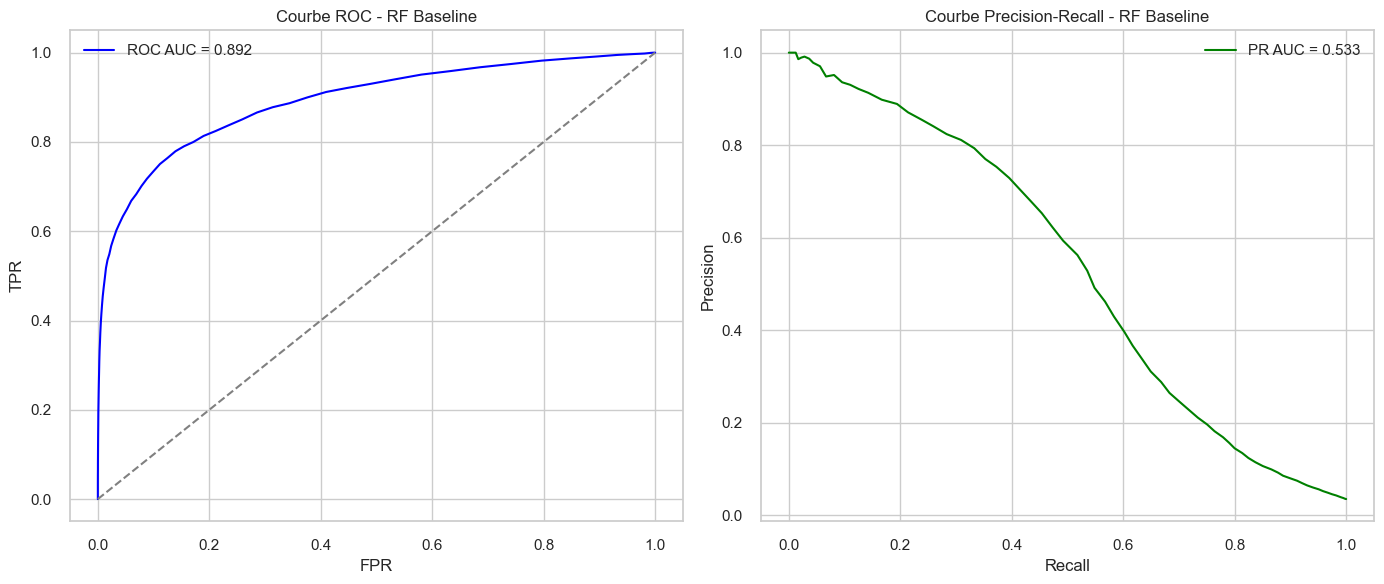

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc


rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_pipeline = rf_model

rf_y_pred_test = rf_pipeline.predict(X_test)
rf_y_proba_test = rf_pipeline.predict_proba(X_test)[:, 1]

logger.info(f"RF AUC (base): {roc_auc_score(y_test, rf_y_proba_test):.3f}")
logger.info(f"RF Classification report: \n{classification_report(y_test, rf_y_pred_test)}")


plot_roc_pr(y_test, rf_y_proba_test, "RF Baseline")

### Random Forest - Hyperparamètres tuning avec GridSearchCV

==> Aucun modèle/seuil trouvé, lancement du GridSearch...
==> Étape 2 : GridSearch + Optimisation du seuil (F1-score)
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best RF params: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
Modèle sauvegardé dans best_rf_model.joblib
Seuil optimal après GridSearch : 0.520
Seuil optimal sauvegardé dans optimal_threshold.npy
=== Rapport classification test ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.66      0.49      0.56      4133

    accuracy                           0.97    118108
   macro avg       0.82      0.74      0.78    118108
weighted avg       0.97      0.97      0.97    118108

F1 train : 1.0000 | F1 test : 0.5648


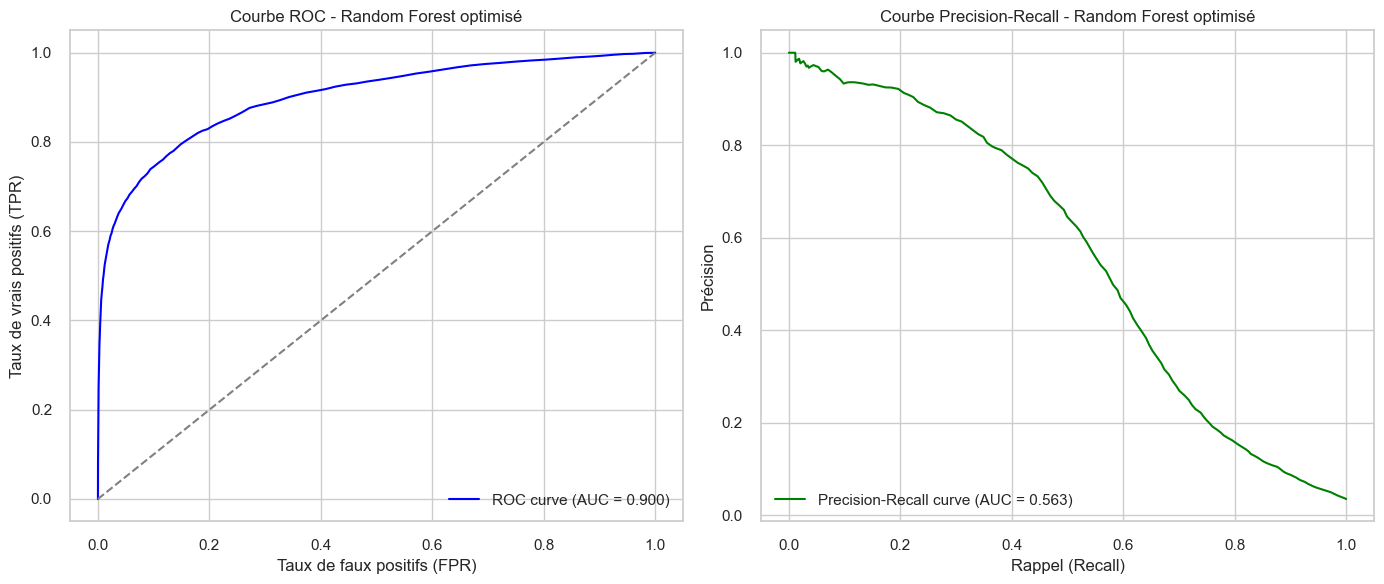

=== Rapport classification final ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.66      0.49      0.56      4133

    accuracy                           0.97    118108
   macro avg       0.82      0.74      0.78    118108
weighted avg       0.97      0.97      0.97    118108



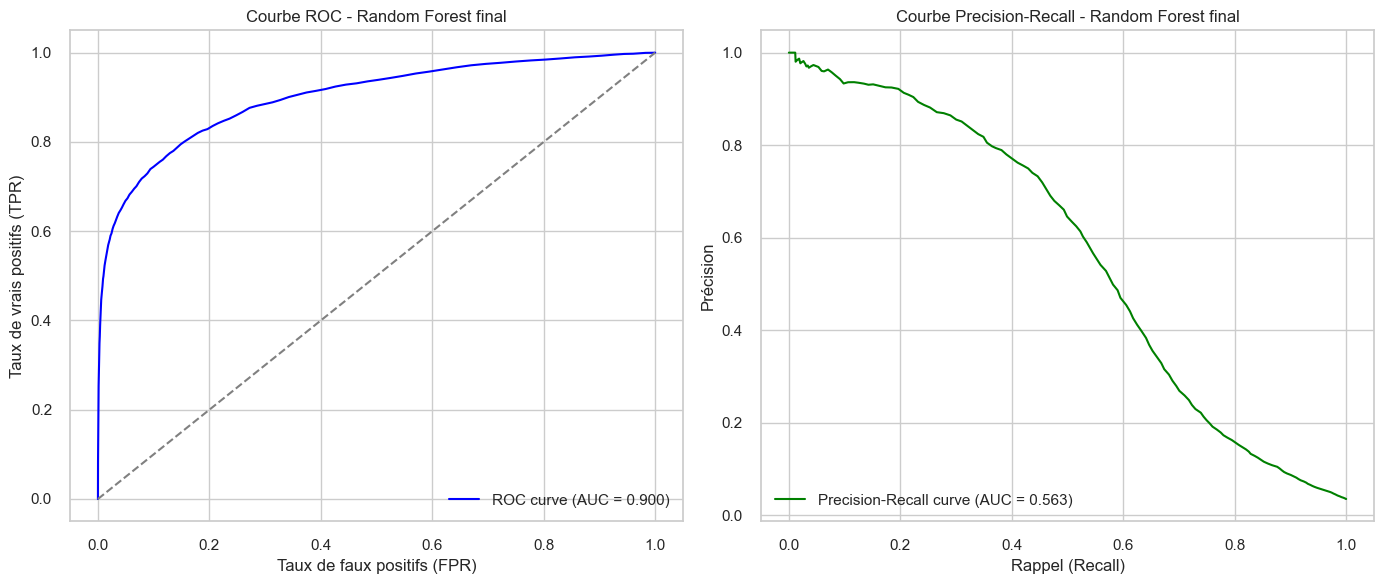

In [ ]:
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report, roc_curve, precision_recall_curve, auc

# === Hyperparamètres ===
rf_param_grid = {
    "n_estimators": [100, 200, 250],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "class_weight": [None, 'balanced']
}

# === Fichiers de sauvegarde ===
model_filename = "best_rf_model.joblib"
threshold_filename = "optimal_threshold.npy"

# === Seuils à tester ===
seuils = np.arange(0.1, 0.9, 0.01)

# === Fonction GridSearch + Optimisation seuil ===
def gridsearch_and_threshold_optimization():
    print("==> Étape 2 : GridSearch + Optimisation du seuil (F1-score)")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

    grid_rf = GridSearchCV(
        rf_model,
        param_grid=rf_param_grid,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=2,
        return_train_score=True
    )

    grid_rf.fit(X_train, y_train)
    print(f"Best RF params: {grid_rf.best_params_}")
    best_rf = grid_rf.best_estimator_

    # Sauvegarde du modèle
    joblib.dump(best_rf, model_filename)
    print(f"Modèle sauvegardé dans {model_filename}")

    # Prédictions probabilistes sur test
    y_test_proba = best_rf.predict_proba(X_test)[:, 1]

    # Optimisation du seuil
    f1_scores = [f1_score(y_test, y_test_proba > s) for s in seuils]
    opt_seuil = seuils[np.argmax(f1_scores)]
    print(f"Seuil optimal après GridSearch : {opt_seuil:.3f}")

    # Sauvegarde du seuil
    np.save(threshold_filename, np.array([opt_seuil]))
    print(f"Seuil optimal sauvegardé dans {threshold_filename}")

    # Évaluation finale
    y_test_pred = (y_test_proba > opt_seuil).astype(int)
    print("=== Rapport classification test ===")
    print(classification_report(y_test, y_test_pred))

    # Score sur train
    y_train_proba = best_rf.predict_proba(X_train)[:, 1]
    f1_train = f1_score(y_train, y_train_proba > opt_seuil)
    f1_test = f1_score(y_test, y_test_pred)
    print(f"F1 train : {f1_train:.4f} | F1 test : {f1_test:.4f}")

    # Visualisation ROC / PR
    plot_roc_pr(y_test, y_test_proba, model_name="Random Forest optimisé")

    return best_rf, opt_seuil

# === Fonction chargement modèle + seuil ===
def load_model_and_threshold():
    if os.path.exists(model_filename) and os.path.exists(threshold_filename):
        print("==> Chargement du modèle et seuil sauvegardés...")
        best_rf = joblib.load(model_filename)
        opt_seuil = np.load(threshold_filename)[0]
        print(f"Seuil chargé : {opt_seuil:.3f}")
        return best_rf, opt_seuil
    else:
        print("==> Aucun modèle/seuil trouvé, lancement du GridSearch...")
        return None, None

# === MAIN ===
best_rf, opt_seuil = load_model_and_threshold()

if best_rf is None or opt_seuil is None:
    best_rf, opt_seuil = gridsearch_and_threshold_optimization()


# Utilisation du modèle chargé ou optimisé
y_test_proba = best_rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > opt_seuil).astype(int)
print("=== Rapport classification final ===")
print(classification_report(y_test, y_test_pred))

# Courbes finales
plot_roc_pr(y_test, y_test_proba, model_name="Random Forest final")


## XGBoost
Gradient Boosting performant, efficace sur données hétérogènes, gère missing values.

XGBoost 
Seuil optimal XGBoost: 0.810
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    113975
           1       0.52      0.41      0.46      4133

    accuracy                           0.97    118108
   macro avg       0.75      0.70      0.72    118108
weighted avg       0.96      0.97      0.96    118108



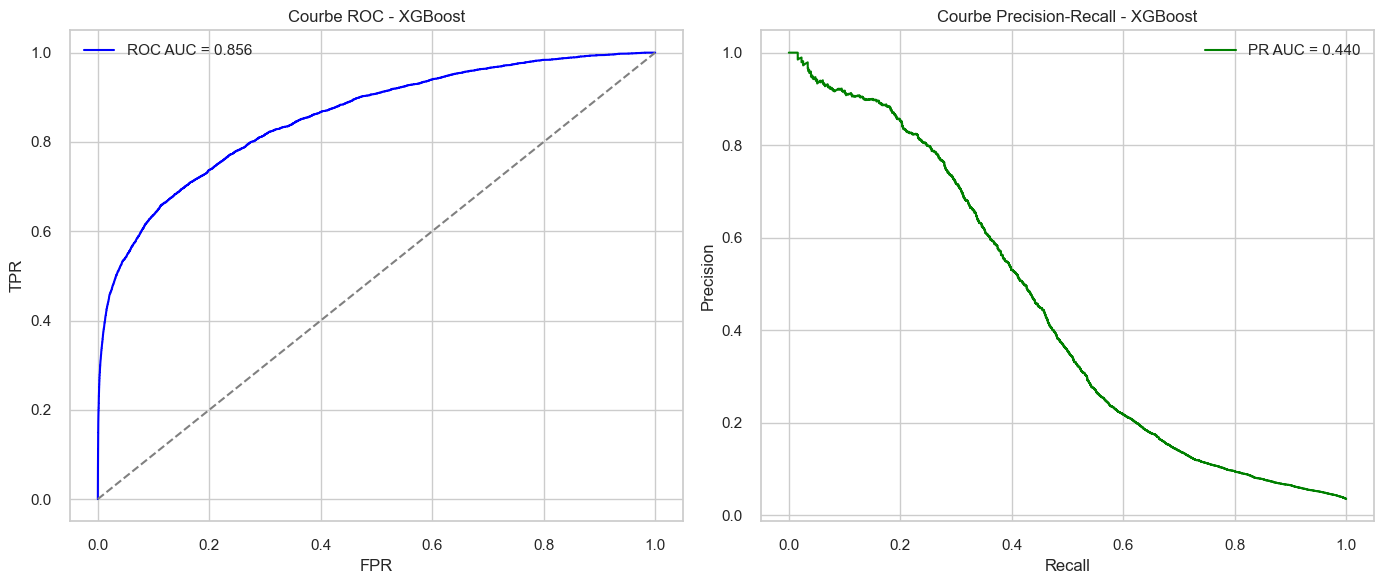

F1 train: 0.9202 - F1 val: 0.4583


In [53]:

# === XGBOOST ===
print("XGBoost ")
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
xgb.fit(X_train, y_train)

y_train_proba = xgb.predict_proba(X_train)[:, 1]
y_val_proba = xgb.predict_proba(X_test)[:, 1]

# Optimisation seuil
f1_scores = [f1_score(y_test, y_val_proba > s) for s in seuils]
opt_seuil_xgb = seuils[np.argmax(f1_scores)]
print(f"Seuil optimal XGBoost: {opt_seuil_xgb:.3f}")

y_val_pred_opt = (y_val_proba > opt_seuil_xgb).astype(int)
print(classification_report(y_test, y_val_pred_opt))

plot_roc_pr(y_test, y_val_proba, "XGBoost")

f1_train = f1_score(y_train, y_train_proba > opt_seuil_xgb)
f1_val = f1_score(y_test, y_val_pred_opt)
print(f"F1 train: {f1_train:.4f} - F1 val: {f1_val:.4f}")


### XGBoost - Hyperparamètres tuning avec GridSearchCV

Aucun modèle XGB trouvé. Lancement entraînement.
==> Lancement du GridSearch XGBoost + optimisation seuil F1
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best XGB params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Modèle XGBoost sauvegardé dans best_xgb_model.joblib
Seuil optimal XGB : 0.640
Seuil sauvegardé dans optimal_threshold_xgb.npy
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    113975
           1       0.57      0.43      0.49      4133

    accuracy                           0.97    118108
   macro avg       0.77      0.71      0.74    118108
weighted avg       0.97      0.97      0.97    118108

F1 train : 0.9260 - F1 test : 0.4881
=== Rapport final XGB ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    113975
           1       0.57      0.43      0.49      4133

    accuracy                           0.97    118108
   macro avg      

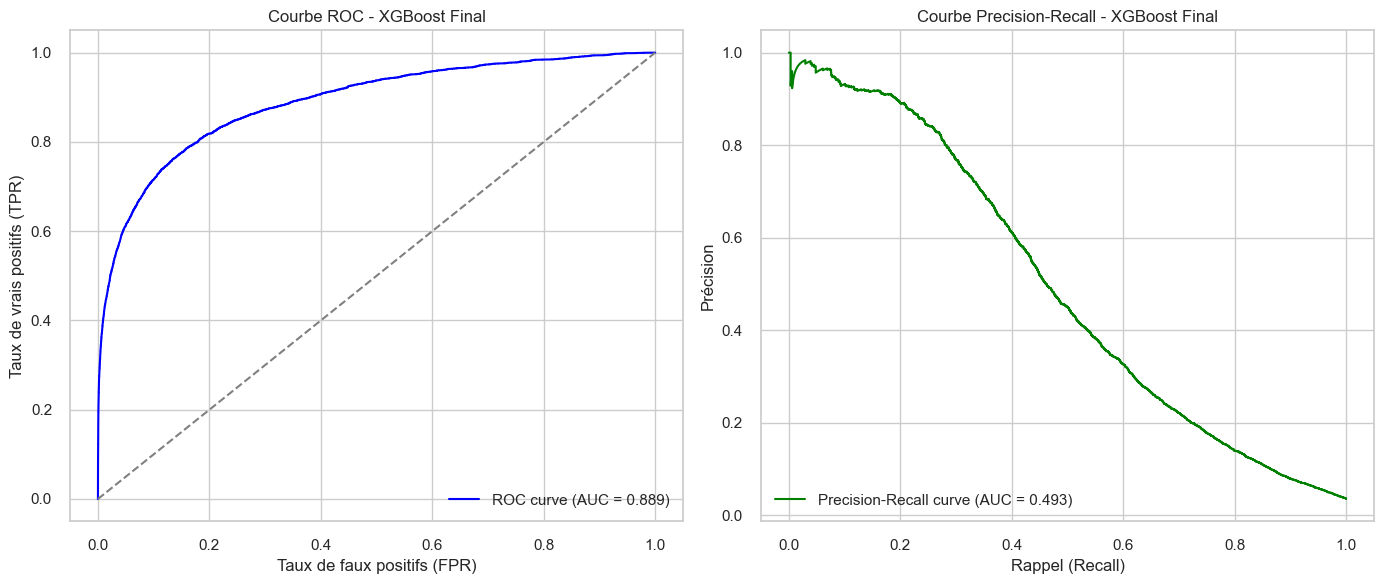

In [ ]:
import numpy as np
import joblib
import os
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report

# === Grille d’hyperparamètres pour XGBoost ===
param_grid_xgb = {
    'n_estimators': [50, 100,150,200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.05]
}

# === Fichiers pour sauvegarde modèle et seuil ===
xgb_model_file = "best_xgb_model.joblib"
xgb_threshold_file = "optimal_threshold_xgb.npy"

# === Seuils à tester ===
seuils = np.arange(0.1, 0.9, 0.01)

# === Fonction : entraînement + optimisation seuil ===
def gridsearch_and_threshold_xgb():
    print("==> Lancement du GridSearch XGBoost + optimisation seuil F1")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model = XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )

    grid = GridSearchCV(
        model,
        param_grid=param_grid_xgb,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=2,
        return_train_score=True
    )

    grid.fit(X_train, y_train)
    print(f"Best XGB params: {grid.best_params_}")

    best_model = grid.best_estimator_

    # Sauvegarder le modèle
    joblib.dump(best_model, xgb_model_file)
    print(f"Modèle XGBoost sauvegardé dans {xgb_model_file}")

    # Prédiction proba
    y_test_proba = best_model.predict_proba(X_test)[:, 1]

    # Optimisation seuil F1
    f1_scores = [f1_score(y_test, y_test_proba > s) for s in seuils]
    best_threshold = seuils[np.argmax(f1_scores)]
    print(f"Seuil optimal XGB : {best_threshold:.3f}")

    # Sauvegarder le seuil
    np.save(xgb_threshold_file, np.array([best_threshold]))
    print(f"Seuil sauvegardé dans {xgb_threshold_file}")

    # Évaluation
    y_test_pred = (y_test_proba > best_threshold).astype(int)
    print(classification_report(y_test, y_test_pred))

    # F1 sur train
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    f1_train = f1_score(y_train, y_train_proba > best_threshold)
    f1_test = f1_score(y_test, y_test_pred)
    print(f"F1 train : {f1_train:.4f} - F1 test : {f1_test:.4f}")


    return best_model, best_threshold

# === Fonction de chargement du modèle/seuil si redémarrage ===
def load_xgb_model_and_threshold():
    if os.path.exists(xgb_model_file) and os.path.exists(xgb_threshold_file):
        print("Chargement modèle XGB et seuil optimisé...")
        model = joblib.load(xgb_model_file)
        threshold = np.load(xgb_threshold_file)[0]
        print(f"Seuil chargé : {threshold:.3f}")
        return model, threshold
    else:
        print("Aucun modèle XGB trouvé. Lancement entraînement.")
        return None, None

# === MAIN ===
best_xgb, best_thresh_xgb = load_xgb_model_and_threshold()

if best_xgb is None or best_thresh_xgb is None:
    best_xgb, best_thresh_xgb = gridsearch_and_threshold_xgb()

# Utilisation du modèle chargé
y_test_proba = best_xgb.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > best_thresh_xgb).astype(int)

print("=== Rapport final XGB ===")
print(classification_report(y_test, y_test_pred))
plot_roc_pr(y_test, y_test_proba, "XGBoost Final")



## CatBoost
Gradient boosting avec traitement spécifique des catégoriques, robuste et précis.

CatBoost
Seuil optimal CatBoost : 0.380
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    113975
           1       0.52      0.41      0.46      4133

    accuracy                           0.97    118108
   macro avg       0.75      0.70      0.72    118108
weighted avg       0.96      0.97      0.96    118108



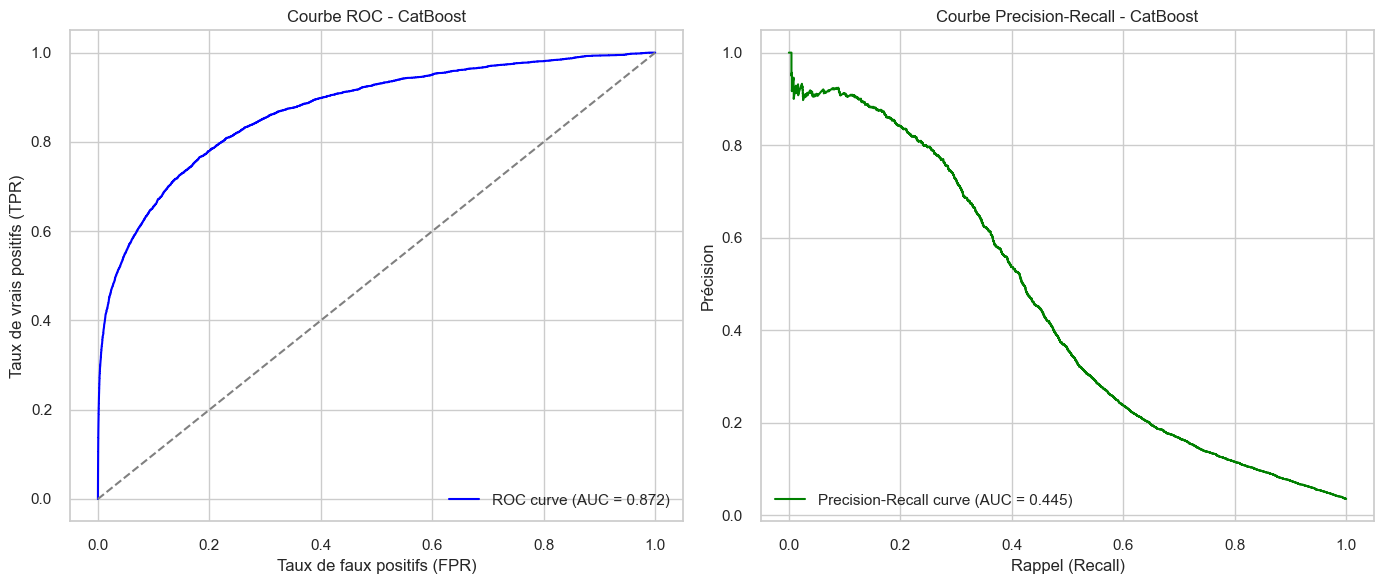

F1 train: 0.9531 - F1 val: 0.4615


In [27]:

# === CATBOOST ===
print("CatBoost")

cat = CatBoostClassifier(random_seed=42, verbose=0)
cat.fit(X_train, y_train)

y_train_proba = cat.predict_proba(X_train)[:, 1]
y_val_proba = cat.predict_proba(X_test)[:, 1]

f1_scores = [f1_score(y_test, y_val_proba > s) for s in seuils]
opt_seuil_cat = seuils[np.argmax(f1_scores)]
print(f"Seuil optimal CatBoost : {opt_seuil_cat:.3f}")

y_val_pred_opt = (y_val_proba > opt_seuil_cat).astype(int)
print(classification_report(y_test, y_val_pred_opt))

plot_roc_pr(y_test, y_val_proba, "CatBoost")

f1_train = f1_score(y_train, y_train_proba > opt_seuil_cat)
f1_val = f1_score(y_test, y_val_pred_opt)
print(f"F1 train: {f1_train:.4f} - F1 val: {f1_val:.4f}")


### CatBoost - Hyperparamètres tuning avec GridSearchCV

Chargement du modèle et seuil CatBoost sauvegardés...
Seuil CatBoost chargé : 0.380
==> Rapport final CatBoost
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    113975
           1       0.52      0.41      0.46      4133

    accuracy                           0.97    118108
   macro avg       0.75      0.70      0.72    118108
weighted avg       0.96      0.97      0.96    118108



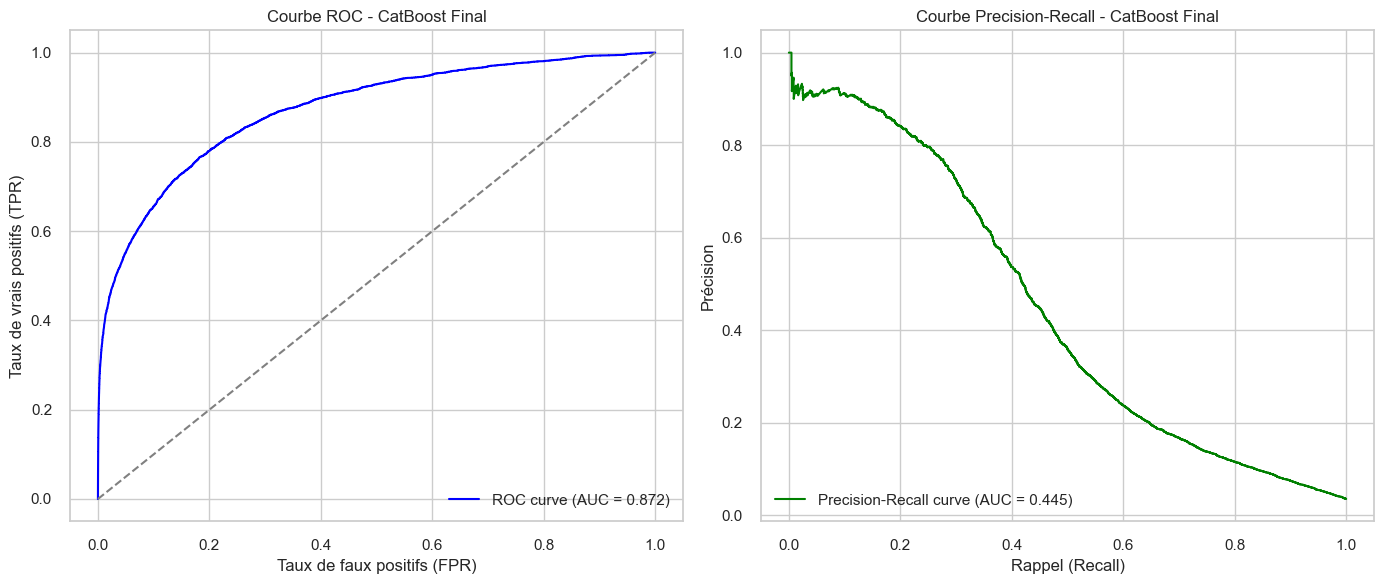

In [28]:

# Paramètres
seuils = np.arange(0.1, 0.9, 0.01)
model_filename = "best_catboost_model.joblib"
threshold_filename = "optimal_threshold_catboost.npy"

def train_and_optimize_catboost():
    print("==> Entraînement CatBoost + optimisation du seuil")

    cat = CatBoostClassifier(random_seed=42, verbose=0)
    cat.fit(X_train, y_train)

    # Sauvegarde du modèle
    joblib.dump(cat, model_filename)
    print(f"Modèle CatBoost sauvegardé dans {model_filename}")

    # Probabilités sur test
    y_test_proba = cat.predict_proba(X_test)[:, 1]
    f1_scores = [f1_score(y_test, y_test_proba > s) for s in seuils]
    opt_seuil = seuils[np.argmax(f1_scores)]
    print(f"Seuil optimal CatBoost : {opt_seuil:.3f}")

    # Sauvegarde du seuil optimal
    np.save(threshold_filename, np.array([opt_seuil]))
    print(f"Seuil CatBoost sauvegardé dans {threshold_filename}")

    # Évaluation sur test
    y_test_pred = (y_test_proba > opt_seuil).astype(int)
    print(classification_report(y_test, y_test_pred))


    # Scores F1
    y_train_proba = cat.predict_proba(X_train)[:, 1]
    f1_train = f1_score(y_train, y_train_proba > opt_seuil)
    f1_test = f1_score(y_test, y_test_pred)
    print(f"F1 train: {f1_train:.4f} - F1 test: {f1_test:.4f}")

    return cat, opt_seuil

def load_catboost_model_and_threshold():
    if os.path.exists(model_filename) and os.path.exists(threshold_filename):
        print("Chargement du modèle et seuil CatBoost sauvegardés...")
        cat = joblib.load(model_filename)
        opt_seuil = np.load(threshold_filename)[0]
        print(f"Seuil CatBoost chargé : {opt_seuil:.3f}")
        return cat, opt_seuil
    else:
        print("Aucun modèle/seuil CatBoost sauvegardé. Entraînement nécessaire...")
        return None, None

# === MAIN CATBOOST ===
cat, opt_seuil_cat = load_catboost_model_and_threshold()
if cat is None or opt_seuil_cat is None:
    cat, opt_seuil_cat = train_and_optimize_catboost()

# Utilisation finale
y_test_proba = cat.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > opt_seuil_cat).astype(int)

print("==> Rapport final CatBoost")
print(classification_report(y_test, y_test_pred))
plot_roc_pr(y_test, y_test_proba, "CatBoost Final")


## LightGBM
Gradient boosting très rapide et scalable, très utilisé en pratique.

LightGBM
[LightGBM] [Info] Number of positive: 68385, number of negative: 136770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12238
[LightGBM] [Info] Number of data points in the train set: 205155, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Seuil optimal LightGBM : 0.660
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    113975
           1       0.56      0.41      0.48      4133

    accuracy                           0.97    118108
   macro avg       0.77      0.70      0.73    118108
weighted avg       0.96      0.97      0.97    118108



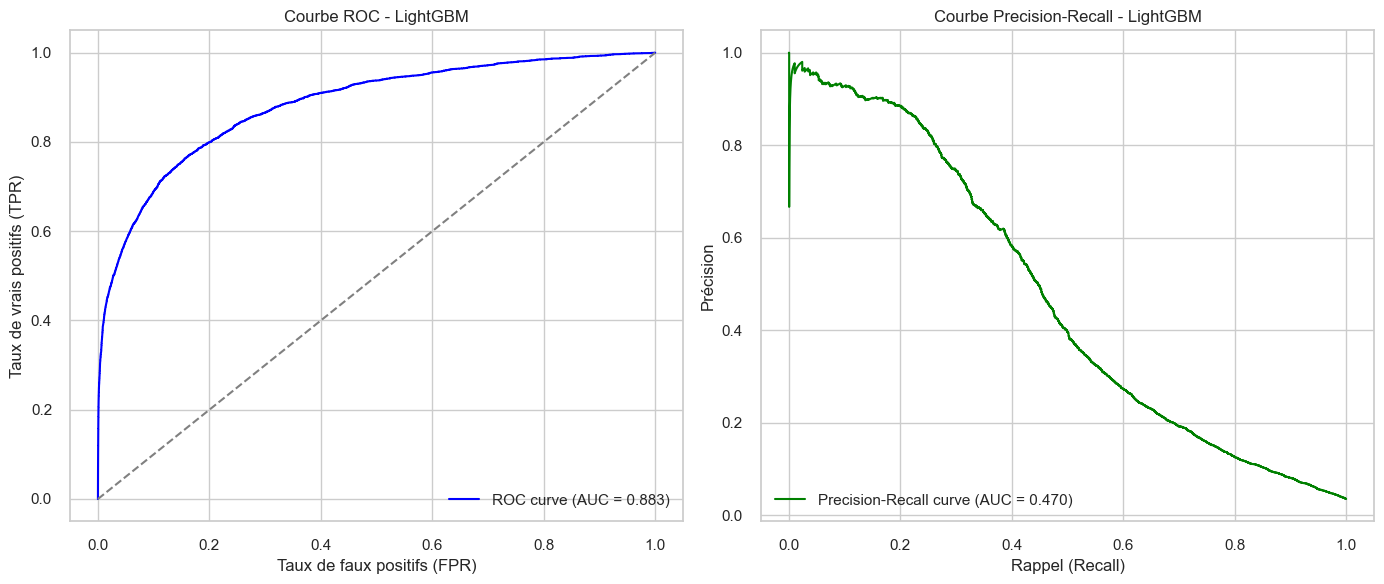

F1 train: 0.9127 - F1 val: 0.4773


In [29]:
X_val = X_test
y_val = y_test
# === LIGHTGBM ===
print("LightGBM")

lgbm = LGBMClassifier(random_state=42, n_jobs=-1)
lgbm.fit(X_train, y_train)

y_train_proba = lgbm.predict_proba(X_train)[:, 1]
y_val_proba = lgbm.predict_proba(X_val)[:, 1]

f1_scores = [f1_score(y_val, y_val_proba > s) for s in seuils]
opt_seuil_lgbm = seuils[np.argmax(f1_scores)]
print(f"Seuil optimal LightGBM : {opt_seuil_lgbm:.3f}")

y_val_pred_opt = (y_val_proba > opt_seuil_lgbm).astype(int)
print(classification_report(y_val, y_val_pred_opt))

plot_roc_pr(y_val, y_val_proba, "LightGBM")

f1_train = f1_score(y_train, y_train_proba > opt_seuil_lgbm)
f1_val = f1_score(y_val, y_val_pred_opt)
print(f"F1 train: {f1_train:.4f} - F1 val: {f1_val:.4f}")


### LightGBM - Hyperparamètres tuning avec GridSearchCV

Chargement du modèle et seuil LightGBM sauvegardés...
Seuil LightGBM chargé : 0.620
==> Rapport final LightGBM
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    113975
           1       0.53      0.36      0.43      4133

    accuracy                           0.97    118108
   macro avg       0.75      0.67      0.71    118108
weighted avg       0.96      0.97      0.96    118108



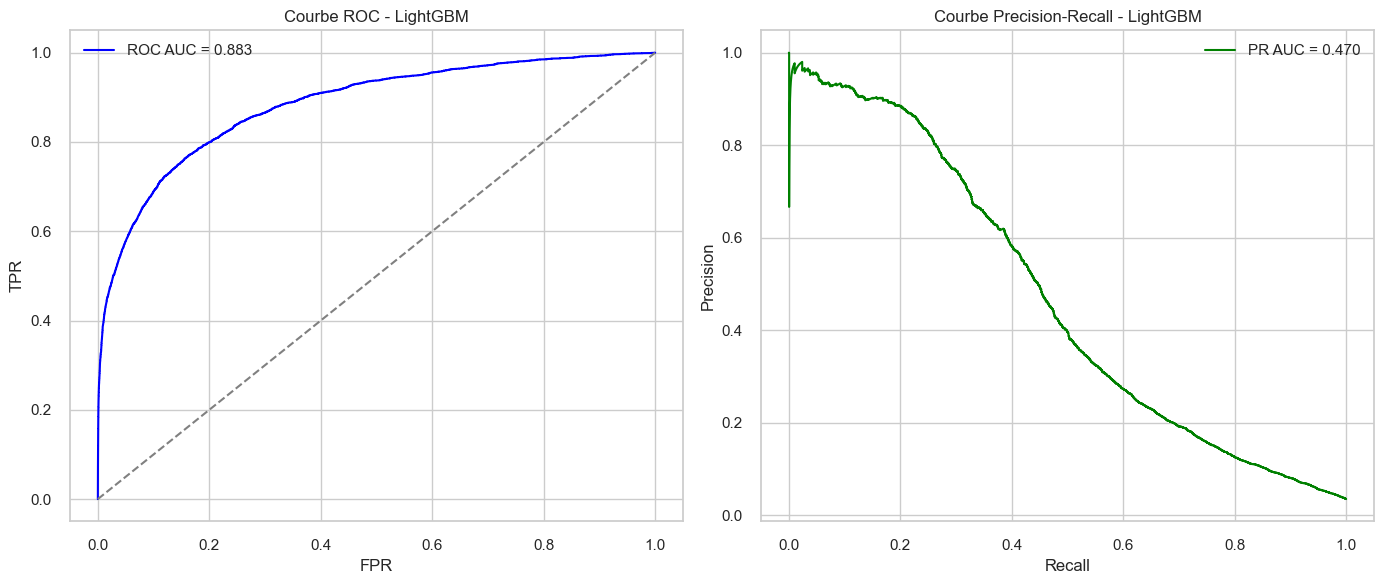

In [33]:
import numpy as np
import os
import joblib
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# === Fonctions ===
def plot_roc_pr(y_true, y_proba, model_name="Modèle"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Courbe ROC - {model_name}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}', color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Courbe Precision-Recall - {model_name}')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# === Paramètres ===
seuils = np.arange(0.1, 0.9, 0.01)
model_filename = "best_lgbm_model.joblib"
threshold_filename = "optimal_threshold_lgbm.npy"

# === Entraînement + GridSearch + Optimisation seuil ===
def train_and_optimize_lgbm():
    print("==> GridSearch + optimisation seuil LightGBM")

    param_grid_lgbm = {
        'n_estimators': [50, 100],
        'max_depth': [10, 20],
        'learning_rate': [0.1, 0.05]
    }

    grid_lgbm = GridSearchCV(
        LGBMClassifier(random_state=42, n_jobs=-1),
        param_grid=param_grid_lgbm,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=2
    )

    grid_lgbm.fit(X_train, y_train)
    print(f"Best LightGBM params: {grid_lgbm.best_params_}")

    best_lgbm = grid_lgbm.best_estimator_

    # Sauvegarder le modèle
    joblib.dump(best_lgbm, model_filename)
    print(f"Modèle LightGBM sauvegardé dans {model_filename}")

    # Probabilités test
    y_test_proba = best_lgbm.predict_proba(X_test)[:, 1]
    f1_scores = [f1_score(y_test, y_test_proba > s) for s in seuils]
    opt_seuil = seuils[np.argmax(f1_scores)]
    print(f"Seuil optimal LightGBM : {opt_seuil:.3f}")

    # Sauvegarder le seuil optimal
    np.save(threshold_filename, np.array([opt_seuil]))
    print(f"Seuil LightGBM sauvegardé dans {threshold_filename}")

    # Évaluation
    y_test_pred = (y_test_proba > opt_seuil).astype(int)
    print(classification_report(y_test, y_test_pred))

    plot_roc_pr(y_test, y_test_proba, "LightGBM")

    # F1 score train/test
    y_train_proba = best_lgbm.predict_proba(X_train)[:, 1]
    f1_train = f1_score(y_train, y_train_proba > opt_seuil)
    f1_test = f1_score(y_test, y_test_pred)
    print(f"F1 train: {f1_train:.4f} - F1 test: {f1_test:.4f}")

    return best_lgbm, opt_seuil

# === Chargement modèle et seuil si dispo ===
def load_lgbm_model_and_threshold():
    if os.path.exists(model_filename) and os.path.exists(threshold_filename):
        print("Chargement du modèle et seuil LightGBM sauvegardés...")
        best_lgbm = joblib.load(model_filename)
        opt_seuil = np.load(threshold_filename)[0]
        print(f"Seuil LightGBM chargé : {opt_seuil:.3f}")
        return best_lgbm, opt_seuil
    else:
        print("Aucun modèle/seuil LightGBM sauvegardé. Entraînement nécessaire...")
        return None, None

# === MAIN ===
best_lgbm, opt_seuil_lgbm = load_lgbm_model_and_threshold()
if best_lgbm is None or opt_seuil_lgbm is None:
    best_lgbm, opt_seuil_lgbm = train_and_optimize_lgbm()

# Utilisation finale
y_test_proba = best_lgbm.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > opt_seuil_lgbm).astype(int)

print("==> Rapport final LightGBM")
print(classification_report(y_test, y_test_pred))
plot_roc_pr(y_val, y_val_proba, "LightGBM")


## Tableau comparatif des performances des modèles après tuning et optimisation du seuil

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# === Comparaison des modèles ===
print("==> Comparaison des modèles sur X_test")

results = []

# Dummy
dummy_pred = dummy.predict(X_test)
dummy_proba = dummy.predict_proba(X_test)[:, 1]
results.append({
    "Model": "Naive",
    "Accuracy": accuracy_score(y_test, dummy_pred),
    "Precision": precision_score(y_test, dummy_pred),
    "Recall": recall_score(y_test, dummy_pred),
    "F1": f1_score(y_test, dummy_pred),
    "AUC": roc_auc_score(y_test, dummy_proba)
})

# Modèles optimisés
models = [best_rf,  best_xgb, cat, best_lgbm ]
names = ["Random Forest", "XGBoost", "CatBoost", "LightGBM"]
seuils_opt = [opt_seuil, best_thresh_xgb,opt_seuil_cat, opt_seuil_lgbm]

for model, name, seuil in zip(models, names, seuils_opt):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > seuil).astype(int)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba)
    })

# Résultats en DataFrame
df_results = pd.DataFrame(results)
df_results.set_index("Model", inplace=True)
df_results = df_results.sort_values("F1", ascending=False)

# Affichage
print("\n==> Résultats des modèles :")
display(df_results.round(3))


==> Comparaison des modèles sur X_test

==> Résultats des modèles :


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Random Forest,0.973,0.661,0.493,0.565,0.900
XGBoost,0.969,0.567,0.429,0.488,0.889
CatBoost,0.966,0.522,0.414,0.461,0.872
LightGBM,0.966,0.527,0.361,0.428,0.860
Naive,0.498,0.035,0.495,0.065,0.500


## Feature Importance
Ci-dessous les features qui ont le plus contribué à la prédiction

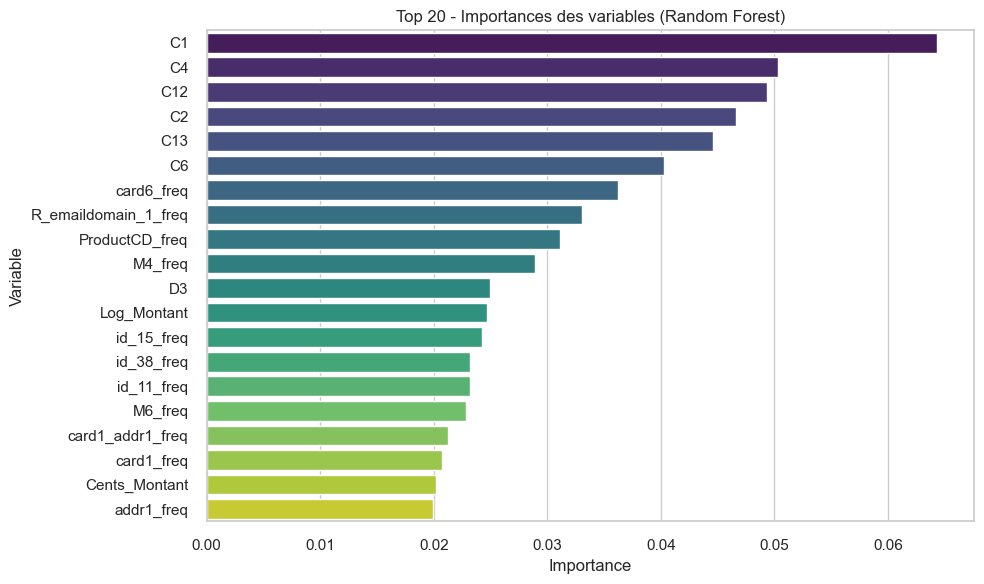

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Récupération des colonnes depuis X_train
feature_names = X_train.columns

# Récupération des importances
importances = best_rf.feature_importances_

# Création d’un DataFrame trié
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Affichage des 20 variables les plus importantes
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp.head(20), y='Feature', x='Importance', palette='viridis')
plt.title("Top 20 - Importances des variables (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

## Test final sur test.csv

In [ ]:
y_test_proba = best_rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > opt_seuil).astype(int)

print(f"Nombre de fraudes détectées : {sum(y_test_pred)} sur {len(y_test_pred)} transactions")


Nombre de fraudes détectées : 3087 sur 118108 transactions
